In [1]:
from __future__ import division
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm

# Week 8 -- Pricing of more complex derivative products

In this week we take a look at the pricing of more complex derivatives. Recall from last week that the payoff of a European Call option only depends on the difference between the strike and the underlying asset at the time of maturity, i.e. payoff = $\text{max}(S_T-K, 0)$. The options in this week go beyond this, and typyically have a more involved payoff structure, different rules on exercising the option (e.g. the option can be exercised at a time different from maturity) or demand some condition on the price of the underlying before the time of maturity.

These extra conditions on the options usually implies that we can no longer obtain a closed-form solution for the price. Luckily we have another technique at our disposal to price these objects...

The pricing of any derivative is the following three-step process:

1. Simulate $M$ trajectories of the underlying (e.g. a stock) over a discretized time-interval. 

2. For each trajectory we determine the payoff

3. Finally, the price of the option is the average of the payoffs of each trajectory ($\frac{1}{M} \sum_{\text{trajectories }}\text{payoff}(\text{trajectory})$), which we discount using the risk-free interest rate.

#### Barrier options -- Up and Out Call

We consider a European up-and-out barrier option. It has the final payoff structure of an ordinary European Call option. In addition, it comes equipped with a Barrier price $B$. If, at any time, the price of the underlying crosses this Barrier (such that $S_t > B$) then the option is nullified and becomes worthless.

In the Black-Scholes model it is possible to obtian a closed-from expression for this price. We will use this to compare our Monte-Carlo pricing scheme to the exact formula. If you are familiar with the deriviation of the pricing of vanilla options in the Black Scholes model, then you probably know that the resulting price of an option is a solution to the heat equation, subject to a particular boundary condition. The pricing of the Barrier option is very similar, but imposes different boundary conditions (i.e. those associated with the Barrier). 

In [2]:
def priceBarrierUpAndOutCall(S0,K,B,r,T,sigma):
    """
    priceBarrierUpAndOutCall: Black-Scholes price of an up and out barrier price option (continuous observations)
    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        B : Up-and-out barrier 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 

    OUTPUT:
    price : Price of the option in the Black-Scholes model  

    """
    
    def compute_d(S0, K, r, sigma, T):
        d1 = (np.log(S0 / K) + (r + .5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d0 = d1 - sigma * np.sqrt(T)
        return d0, d1
    
    
    mu = r - 0.5 * sigma**2
    nu = 2.0* mu / sigma**2
    
    aux1 = (B/S0)**(nu+2)
    aux2 = (B/S0)**(nu)
    
    K_disc = K * np.exp(-r * T) 
    
    d0, d1  = compute_d(S0,K,r,sigma,T)
    price   = S0 * norm.cdf(d1) - K_disc * norm.cdf(d0)
    
    d0, d1  = compute_d(S0,B,r,sigma,T)
    price   = price - S0 * norm.cdf(d1) + K_disc * norm.cdf(d0)
    
    d0, d1  = compute_d(1.0/S0, 1.0/B, r, sigma, T)
    price   = price + aux1 * S0 * norm.cdf(d1) - aux2 * K_disc * norm.cdf(d0)
    
    d0, d1  = compute_d(1./(K * S0), 1/B**2, r, sigma, T)
    price   = price - aux1 * S0 * norm.cdf(d1) + aux2 * K_disc * norm.cdf(d0)
  
    return price

We first define a generic Monte Carlo scheme for determining the price of an option. It only assumes the underlying is modelled using a geometric Brownian motion, and requires as an input the payoff function of the option. 

In [10]:
def priceOptionMC(S0,r,T,sigma,M,N, payoff_function):
    """
    priceOptionMC: Black-Scholes price of a generic option providing a payoff.
    INPUT:
       S0 : Initial value of the underlying asset
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
        N : Number of observations
    payoff_function : payoff function of the option
    
    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  

    """
    
    ## Generate M x N samples from N(0,1)
    X = np.random.randn(M, N)

    
    ## Simulate M trajectories in N steps
    deltaT = T / N
    e = np.exp((r-0.5*sigma**2) * deltaT  + sigma * np.sqrt(deltaT) * X)
    S = np.cumprod(np.c_[S0 * np.ones((M,1)), e], axis=1)        
        
        
    ## Compute the payoff for each trajectory
    payoff = payoff_function(S)

    
    ## MC estimate of the price and the error of the option
    discountFactor = np.exp(-r*T);
    
    
    price_MC = discountFactor * np.mean(payoff)
    stdev_MC = discountFactor * np.std(payoff)/np.sqrt(M)
    return price_MC, stdev_MC

Next we consider the Barrier Up and Out Call option

In [11]:
def priceBarrierUpAndOutCallMC(S0,K,B,r,T,sigma,M,N):
    """
    priceBarrierUpAndOutCallMC: Black-Scholes price of an up and out barrier call option 
    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike |
        B : Up-and-out barrier 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
        N : Number of observations

    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  

    """
    def payoff_function(S):
        return np.where(S[:, -1] < K, 0, S[:, -1] - K) * np.all(S < B, axis=1)
    
    return priceOptionMC(S0,r, T, sigma, M, N, payoff_function)

Here we have a comparison:

In [12]:
def comparePriceBarrier():
    S0 = 100
    K = 90
    B = 160
    r = .05
    T = .1
    sigma = .4

    
    price = priceBarrierUpAndOutCall(S0,K,B,r,T,sigma)
    
    M = 100000
    N = 20
    
    price_MC, stdev_MC = priceBarrierUpAndOutCallMC(S0,K,B,r,T,sigma,M,N)    

    return price, price_MC, stdev_MC, (price - price_MC) / price

print "True price, Price estimate, std answer, True error:"
print comparePriceBarrier()

True price, Price estimate, std answer, True error:
(11.69842813465057, 11.765310551190055, 0.034764991324643363, -0.0057172139512812418)


Note that the estimated variance of the MC price does not take into account the error that arises due to the discretization `N`.

#### Asian options

In an Asian option the final payoff of the option is decided by comparing the strike K with the mean of the underlying at a set number of times preceding the option. So instead of comparing K to the final price at maturity S_T, we compare it with the mean of the price S(t) at times $t_1, t_2, ..., t_{N-1}, t_N = T$. with $t_i < T$ for $i=1, ..., N-1$.

There are two versions of Asian option: we can take the arithmic mean ($\frac{1}{N}\sum_{i=1}^N S(t_i)$) or the geometric mean $\exp\big(\frac{1}{N}\sum_{i=1}^N \log(S_i)\big)$. The geometric mean has the advantage of allowing for a closed expression, which we implement now.

In [19]:
def priceAsianGeometricMeanCall(S0,K,r,T,sigma,N):
    """
    priceAsianGeometricMeanCall: Price of a Asian call option on the geometric mean in the Black-Scholes model
    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        N : Number of monitoring times

    OUTPUT:
    price : Price of the option in the Black-Scholes model  
    """

    ## Auxiliary parameters
    r_GM     = 0.5 * (r * (N+1) / N - sigma**2 * (1.0 - 1.0/N**2) / 6.0)
    sigma_GM = sigma * np.sqrt((2.0 * N**2 + 3.0 * N + 1.0) / (6.0 * N**2))
    
    d_plus  = np.log(S0/(K*np.exp(-r_GM*T)))/(sigma_GM*np.sqrt(T)) + sigma_GM*np.sqrt(T)/2.0
    d_minus = d_plus - sigma_GM*np.sqrt(T)
    
    
    ## Pricing formula
    price = np.exp(-r*T)*(S0*np.exp(r_GM*T)*norm.cdf(d_plus)-K*norm.cdf(d_minus))
    
    return price

Again, we are not interested in where this expression comes from -- we only use it to bench the MC approach.


For the MC implementation we only need to define the payoff function. Note that we can set the discretization of the geometric Brownian motion equal to the number of observations in the Asian option.

In [20]:
def priceAsianGeometricMeanCallMC(S0,K,r,T,sigma,M,N):
    """
    priceAsianGeometricMeanCallMC: Price of a Asian call option on the geometric mean in the Black-Scholes model

    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
        N : Number of observations

    OUTPUT:
        price_MC : MC estimate of the price of the option in the Black-Scholes model  
        stdev_MC : MC estimate of the standard deviation  
    """
    def payoff(S):
        S_mean = np.exp(np.mean(np.log(S[:, 1:]), 1))
        return np.where(S_mean < K, 0, S_mean -K)
    
    return priceOptionMC(S0,r,T,sigma,M,N, payoff)

And we compare these two pricing schemes again.

In [22]:
def comparePriceAsianGeometric():
    S0 = 100; r = 0.05; K = 90; T = 2; sigma = 0.4; N = 24;
    M = 1000000;
    
    price = priceAsianGeometricMeanCall(S0,K,r,T,sigma,N)   
    price_MC, stdev_MC = priceAsianGeometricMeanCallMC(S0,K,r,T,sigma,M,N)    

    return price, price_MC, stdev_MC, (price - price_MC) / price

print "True price, Price estimate, std answer, True error:"
print comparePriceAsianGeometric()

True price, Price estimate, std answer, True error:
(18.200498107337555, 18.154317605862381, 0.02579511618189579, 0.0025373207481918427)


Finally, let's price an option for which we do not have a closed expression: an Asian option which makes use of the arithmetic mean. We have 

In [23]:
def priceAsianArithmeticMeanCallMC(S0,K,r,T,sigma,M,N):
    """
    priceAsianArithmeticMeanCall: Price of a Asian call option on the arithmetic mean in the Black-Scholes model

    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
        N : Number of observations

    OUTPUT:
      price_MC : MC estimate of the price of the option in the Black-Scholes model
      stdev_MC : MC estimate of the standard deviation  
%
%% EXAMPLE:   
%        S0 = 100; K = 90; r = 0.05; T = 2; sigma = 0.4;
%        M = 1e5; N = 24;
%        [price_MC,stdev_MC] = priceAsianArithmeticMeanCallMC(S0,K,r,T,sigma,M,N)
    """
    def payoff(S):
        S_ar_mean = np.mean(S[:, 1:], 1)
        return np.where(S_ar_mean < K, 0, S_ar_mean - K)
    return priceOptionMC(S0,r,T,sigma,M,N, payoff)

In [26]:
def examplePriceArithmeticAsian():
    S0 = 100; K = 90; r = 0.05; T = 2; sigma = 0.4;
    M = 100000; N = 24;
    return priceAsianArithmeticMeanCallMC(S0,K,r,T,sigma,M,N)

In [27]:
examplePriceArithmeticAsian()

(20.149155980229875, 0.090519705095568101)

#### Asian Options -- Using the geometric Asian option as a control variate for the arithmetic Asian option.

Since we can solve the geometric case exactly, we can compare the quality of the MC simulation to the exact price. This is not the case for the arithmetic mean for which we do not have an exact solution. However, we know that the geometric and arithmetic pricing schemes are highly correlated if we use the same simulations to evaluate their prices. Put differently, the error of the geometric Asian option will be highly correlated to the error in the arithmetic option, if we use the same simulation.

In [34]:
def priceOptionMCWithSAsInput(S, r, T, M, payoff_function):
    """
    priceOptionMC: Black-Scholes price of a generic option providing a payoff.
    INPUT:
        S : A set of pre-computed simulations of Brownian motion
        r : Risk-free interest rate
        M : Number of simulations
        T : Time to maturity
    payoff_function : payoff function of the option
    
    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  

    """
   
    ## Compute the payoff for each trajectory
    payoff = payoff_function(S)

    
    ## MC estimate of the price and the error of the option
    discountFactor = np.exp(-r*T);
        
    price_MC = discountFactor * np.mean(payoff)
    stdev_MC = discountFactor * np.std(payoff)/np.sqrt(M)
    return payoff, price_MC, stdev_MC

In [35]:
def  priceAsianArithmeticMeanCallMC_withControlVariate(S0,K,r,T,sigma,M,N):
    """
    priceOptionMC: Black-Scholes price of a generic option providing a payoff.
    
    INPUT:
       S0 : Initial value of the underlying asset
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
        N : Number of observations
    payoff_function : payoff function of the option
    
    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  

    """
    
    ## Generate M x N samples from N(0,1)
    X = np.random.randn(M, N)

    ## Simulate M trajectories in N steps
    deltaT = T / N
    e = np.exp((r-0.5*sigma**2) * deltaT  + sigma * np.sqrt(deltaT) * X)
    S = np.cumprod(np.c_[S0 * np.ones((M,1)), e], axis=1)        
        
    def arithmeticMean(S):
        S_mean = np.mean(S[:, 1:], 1)
        return np.where(S_mean < K, 0, S_mean - K)
        
    def geometricMean(S):
        S_mean = np.exp(np.mean(np.log(S[:, 1:]), 1))
        return np.where(S_mean < K, 0, S_mean - K)    
        
        
    payoff_ar, price_ar, std_ar = priceOptionMCWithSAsInput(S, r, T, M, arithmeticMean)
    payoff_geom, price_geom, std_geom = priceOptionMCWithSAsInput(S, r, T, M, geometricMean)
    price_geom_exact = priceAsianGeometricMeanCall(S0,K,r,T,sigma,N)
    
    
    covarianceMatrix = np.cov(np.c_[payoff_ar, payoff_geom].T)
    
    var_ar = covarianceMatrix[0,0]
    var_geom = covarianceMatrix[1,1]
    cov_ar_geom = covarianceMatrix[0,1]
    
    corr_ar_geom = cov_ar_geom / np.sqrt(var_ar * var_geom)
    
    
    price_MC = price_ar - cov_ar_geom / var_geom * (price_geom - price_geom_exact)
    std_MC = std_ar * np.sqrt(1 - corr_ar_geom**2)
    return price_MC, std_MC

For example:

In [36]:
priceAsianArithmeticMeanCallMC_withControlVariate(100, 50, .01, .5, .05, 1000, 20)

(50.012235078450139, 0.00029203812324037716)

Let's compare it with the straightforward MC method:

In [39]:
def examplePriceArithmeticAsian():
    S0 = 100; K = 90; r = 0.05; T = 2; sigma = 0.4;
    M = 100000; N = 24;
    price_direct, std_direct =  priceAsianArithmeticMeanCallMC(S0,K,r,T,sigma,M,N)
    price_control, std_control = priceAsianArithmeticMeanCallMC_withControlVariate(S0,K,r,T,sigma,M,N)
    return price_direct, std_direct, price_control, std_control

In [40]:
print "Price of direct MC method, std of direct MC method, price using control, std using control:"
print examplePriceArithmeticAsian()

Price of direct MC method, std of direct MC method, price using control, std using control:
(19.78591467368582, 0.089191044407118072, 19.993396653598943, 0.006977173060555346)


Note the large reduction in variance using the control variate.

#### Towards basket options: multivariate Guassians

The last exotic option we treat are so-called basket options. For this we require a random number generator which draws samples from a multivariate Gaussian distribution. Such a distribution is characterized by a $D$-dimensional vector of means, $\lbrace\mu_i\rbrace_{i=0}^{D-1}$ and a $(D\times D)$ dimensional covariance matrix $\Sigma_{ij}$. 

The method employed below draws samples from a standardized normal distribution, and then transforms this into the appropriate multivariate Guassian distribution using the Cholesky decomposition of the covariance matrix. The method briefly described here:

https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution

In [41]:
from scipy.linalg import cholesky

In [42]:
def multivariateGaussianRand(M, mu, Sigma):
    """
    multivariateGaussianRand: Generate random numbers from a D-dimensional Gaussian

    INPUT:
         M : size of the sample
        mu : vector of means   [D,1]
     Sigma : covariance matrix [D,D]

    OUTPUT:
         Z : Sample from N(mu,Sigma) Gaussian  [M,D]  
    """
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    
    D = mu.size
    
    L = cholesky(Sigma).T
    
    ## Generate M samples of D-dimensional vectors of independent Gaussians 
    X = np.random.randn(D, M)
    
    
    ## Transform vectors into vectors with proper mean and correlations
    Z = mu[:, np.newaxis] + np.dot(L, X)
    return Z.T

For example,

In [43]:
print multivariateGaussianRand(5, [1,2,3], [[1, .8,.1], [.8, 1, .2], [.1, .2, 1]])

[[ 0.68488522  2.18755775  2.87128716]
 [-1.15250527  1.04889454  3.29193296]
 [ 1.40573528  2.64116626  2.58168144]
 [ 1.2944673   2.15561768  3.31569123]
 [-0.20509657  1.30812482  2.74817267]]


Below we plot the case of a 2D gaussian distribution. 

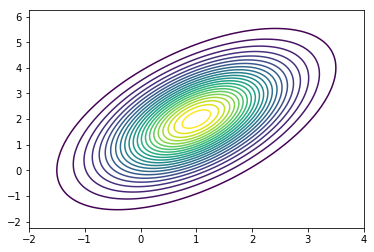

In [44]:
from scipy.linalg import det, inv
def graph2DGaussian(mu, Sigma, alpha=3, nContours=25):
    ## Generate 2-dimensional grid
    nPlot = 100
    Sigma = np.asarray(Sigma).astype(np.float)

    mu = np.asarray(mu).astype(np.float)
    
    radii = alpha * np.diag(np.sqrt(Sigma))

    z1 = np.linspace(mu[0] - radii[0], mu[0] + radii[0], nPlot)
    z2 = np.linspace(mu[1] - radii[1], mu[1] + radii[1], nPlot)
    
    [Z1, Z2] = np.meshgrid(z1,z2)

    detSigma = det(Sigma)
    invSigma = inv(Sigma)
    
    z = (np.r_[Z1[np.newaxis],Z2[np.newaxis]] - mu[:, np.newaxis, np.newaxis] )
    
    # To make use of vectorization (i.e. avoid looping) we need some clever broadcasting of the indices.
    z = z[..., np.newaxis]
    zT = np.swapaxes(z, 0, 3)    
    invSigma = invSigma[:, np.newaxis, np.newaxis, :]
    
    f = np.exp(- .5 * (zT * invSigma * z).sum(axis=(0, 3))) / (2 * np.pi * np.sqrt(detSigma))

    fig = plt.figure()
    plt.contour(Z1, Z2, f, nContours)

    plt.show()
    
    
    
graph2DGaussian([1, 2], [[1., .8], [.8, 2]])

#### Basket Options -- pricing scheme

A basket option is an option on an underlying which is comprised out of a weighted average of other assets. For example, an index fund is a portfolio of assets with the weight $a_i$ of each asset $S_i$ is given by the number of assets $S_i$ in the portfolio (or basket). The price of the portfolio is then the weighted average $U(t) = \sum_i a_i S_i(t)$. A basket call option with strike $K$ is then determined by the payoff $\text{max}(U(T) - K, 0)$. In this case of a simple portfolio the option is also known as a portfolio option.

In the Black-Scholes model the stocks in the portfolio are modeled by geometric Brownian motion. However, the sum of lognormal distributions is itself not a lognormal distribution, so the portfolio cannot be modeled using geometric Brownian motion. 

The portfolio and corresponding basket option become even more interesting when we consider correlated assets. This can be performed using the language of multivariate Gaussians as introduced above.

To price a basket option using MC for correlated assets we need to go back to the drawing board. Here we only look at the case of an option consisting of two options. For each stock we have the initial $S_0$, the volatility $\sigma_i$ and weight in the portfolio $c$. 

In [50]:
def priceBasket2CallMC(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho,M):
    """
    priceBasket2CallMC: Price of a call option on a 2 asset basket in the Black-Scholes model

    INPUT:
      S1_0 : Initial value of the underlying asset I
      S2_0 : Initial value of the underlying asset II
        c1 : coefficient of asset I  in the basket
        c2 : coefficient of asset II in the basket
         K : Strike 
         r : Risk-free interest rate 
         T : Time to expiry 
    sigma1 : Volatility of asset I
    sigma2 : Volatility of asset II
       rho : Correlation between the asset log-returns
         M : Number of simulations

    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  
EXAMPLE:   
%        S1_0 = 100; c1 = 0.4; sigma1 = 0.2;
%        S2_0 = 200; c2 = 0.3; sigma2 = 0.4;
%        rho = 0.5;
%        K = 90; r = 0.05; T = 2; 
%        M = 1e6; 
%        [price_MC,stdev_MC] = priceBasket2CallMC(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho,M)
%        price = priceBasket2Call(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho)
    """
    
    ## Generate M x 2 independent samples from N(0,1)
    X1 = np.random.randn(M)
    X2 = np.random.randn(M)
    
    ## Generate M x 2 correlated samples from N(0,rho)
    Z1 = X1
    Z2 = rho * X1 + np.sqrt(1 - rho**2) * X2
    
    ### Note that we could also use our function multivariateGaussianRand to generate these samples.
    
    ## Simulate M trajectories in one step
    S1_T = S1_0 * np.exp((r - 0.5 * sigma1**2) * T + sigma1 * np.sqrt(T) * Z1)
    S2_T = S2_0 * np.exp((r - 0.5 * sigma2**2) * T + sigma2 * np.sqrt(T) * Z2)
    
    ## Compute the payoff
    basketValue = c1 * S1_T + c2 * S2_T
    payoff      = np.where(basketValue < K, 0, basketValue - K)
    
    ## MC estimate of the price and the error of the option
    discountFactor = np.exp(-r*T)
    price_MC = discountFactor*np.mean(payoff)
    stdev_MC = discountFactor*np.std(payoff)/np.sqrt(M)
    return price_MC, stdev_MC

In [51]:
priceBasket2CallMC(100, 100, .6, .4, 90, .01, 2, .2, .4,.5, 1000000)

(19.488025130867452, 0.02941296767163893)

The price of a 2-asset basket option can also be obtained from an integral, which we approximate using numerical integration. This integral is simply the expected value of the payoff of the function function average with respect to the distribution of the two underlying assets at the time of maturity.

In [56]:
from scipy.integrate import quad

def priceBasket2Call(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho):
    """
    priceBasket2CallMC: Price of a call option on a 2 asset basket in the Black-Scholes model

    INPUT:
      S1_0 : Initial value of the underlying asset I
      S2_0 : Initial value of the underlying asset II
        c1 : coefficient of asset I  in the basket
        c2 : coefficient of asset II in the basket
         K : Strike 
         r : Risk-free interest rate 
         T : Time to expiry 
    sigma1 : Volatility of asset I
    sigma2 : Volatility of asset II
       rho : Correlation between the asset log-returns

    OUTPUT:
     price: Price of the option in the Black-Scholes model  

      USES:
     integrand_priceBasket2Call.m
%
%% EXAMPLE:   
%        S1_0 = 100; c1 = 0.4; sigma1 = 0.2;
%        S2_0 = 200; c2 = 0.3; sigma2 = 0.4;
%        rho = 0.5;
%        K = 90; r = 0.05; T = 2; 
%        price = priceBasket2Call(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho)
%        M = 1e6;
%        [price_MC,stdev_MC] = priceBasket2CallMC(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho,M)
    """

    ## External integrand
    def externalIntegrand(x1):
        return norm.pdf(x1) * integrand_priceBasket2Call(x1,S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho)


    ## Pricing formula          
    discountFactor = np.exp(-r*T)
    
    R     = 10.0
    TOL   = 1.0e-4
    price = discountFactor * quad(externalIntegrand, -R, R, epsabs=TOL, epsrel=TOL)[0]
    return price

And the externalIntegrand is defined as

In [57]:
def integrand_priceBasket2Call(x1,S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho):
    """
    integrand_priceBasket2Call: auxiliary function for priceBasket2Call
    INPUT:
        x1 : integration variable
      S1_0 : Initial value of the underlying asset I
      S2_0 : Initial value of the underlying asset II
        c1 : coefficient of asset I  in the basket
        c2 : coefficient of asset II in the basket
         K : Strike 
         r : Risk-free interest rate 
         T : Time to expiry 
    sigma1 : Volatility of asset I
    sigma2 : Volatility of asset II
       rho : Correlation between the asset log-returns

    OUTPUT:
     externalIntegrand : External integrand to price of the option in the Black-Scholes model  
    """
    def S1_T(x2):
        return S1_0 * np.exp((r-0.5*sigma1**2) * T + sigma1 * np.sqrt(T) * x1)
    def S2_T(x2):
        return S2_0 * np.exp((r-0.5*sigma2**2) * T + sigma2 * np.sqrt(T) * (rho * x1+np.sqrt(1-rho**2)*x2))      

    
    def basketValue(x2):
        return c1 * S1_T(x2) + c2 * S2_T(x2)
    def payoff(x2):
        p = basketValue(x2) - K
        return np.max([p, 0])
    def internalIntegrand(x2):
        return norm.pdf(x2) * payoff(x2)
    
    R   = 10.0;
    TOL = 1.0e-4;
        
    externalIntegrand = quad(internalIntegrand,-R,R, epsabs=TOL, epsrel=TOL)[0]
    return externalIntegrand

Finally, we compare the two methods:

In [59]:
def example():
    S1_0 = 100; c1 = 0.4; sigma1 = 0.2;
    S2_0 = 200; c2 = 0.3; sigma2 = 0.4;
    rho = 0.5;
    K = 90; r = 0.05; T = 2; 
    price = priceBasket2Call(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho)
    M=1000000
    price_MC, std_MC = priceBasket2CallMC(S1_0,S2_0,c1,c2,K,r,T,sigma1,sigma2,rho,M)
    return price, price_MC
print example()
plt.show()

(25.445726651882392, 25.453696130870718)
